In [4]:
data <- read.csv("sdg7_renewable_energy_percent.csv")
head(data)
summary(data)

,Year,Renewable_Energy_Percent
,<int>,<dbl>
1,1990,12.75
2,1991,12.26
3,1992,13.91
4,1993,15.69
5,1994,13.52
6,1995,13.99


      Year      Renewable_Energy_Percent
 Min.   :1990   Min.   :12.26           
 1st Qu.:1998   1st Qu.:15.98           
 Median :2006   Median :18.19           
 Mean   :2006   Mean   :19.30           
 3rd Qu.:2014   3rd Qu.:22.46           
 Max.   :2022   Max.   :29.31           

In [9]:
install.packages("tseries")

Installing package into 'C:/Users/micha/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'tseries' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\micha\AppData\Local\Temp\RtmpW0UmQZ\downloaded_packages


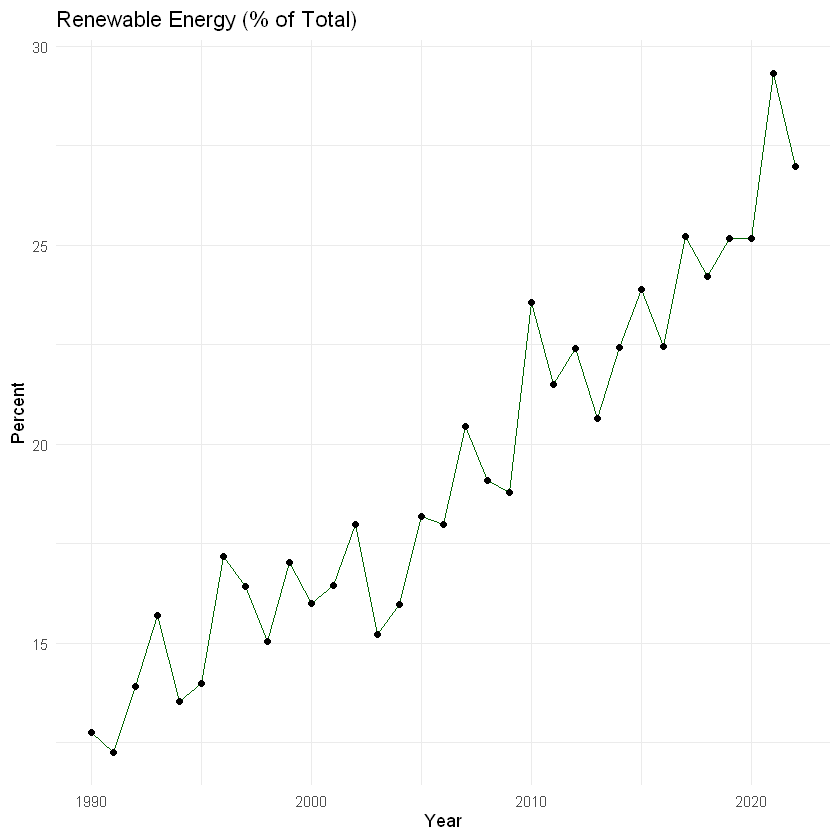

In [5]:
library(ggplot2)

ggplot(data, aes(x = Year, y = Renewable_Energy_Percent)) +
  geom_line(color = "darkgreen") +
  geom_point() +
  labs(title = "Renewable Energy (% of Total)", y = "Percent", x = "Year") +
  theme_minimal()

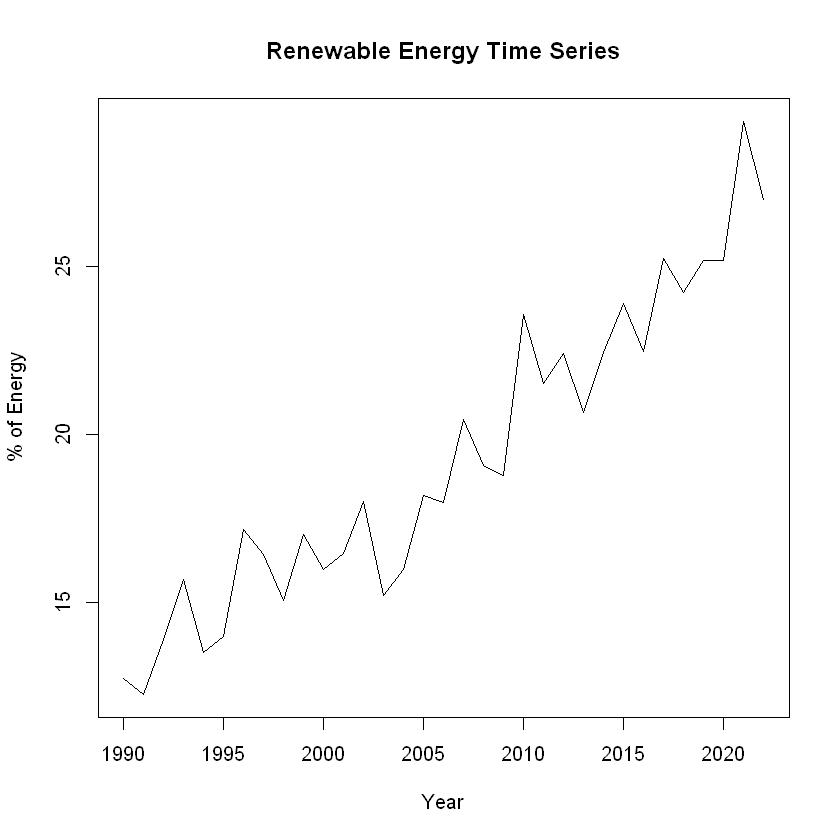

In [6]:
ts_data <- ts(data$Renewable_Energy_Percent, start = 1990, frequency = 1)
plot(ts_data, main = "Renewable Energy Time Series", ylab = "% of Energy", xlab = "Year")


In [10]:
install.packages("forecast")

Installing package into 'C:/Users/micha/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)

also installing the dependencies 'colorspace', 'fracdiff', 'lmtest', 'timeDate', 'urca', 'RcppArmadillo'




package 'colorspace' successfully unpacked and MD5 sums checked
package 'fracdiff' successfully unpacked and MD5 sums checked
package 'lmtest' successfully unpacked and MD5 sums checked
package 'timeDate' successfully unpacked and MD5 sums checked
package 'urca' successfully unpacked and MD5 sums checked
package 'RcppArmadillo' successfully unpacked and MD5 sums checked
package 'forecast' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\micha\AppData\Local\Temp\RtmpW0UmQZ\downloaded_packages


In [11]:
library(tseries)

adf.test(ts_data)  # Augmented Dickey-Fuller Test

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 




	Augmented Dickey-Fuller Test

data:  ts_data
Dickey-Fuller = -1.4986, Lag order = 3, p-value = 0.7668
alternative hypothesis: stationary


In [12]:
library(forecast)

model <- auto.arima(ts_data)
summary(model)

Series: ts_data 
ARIMA(0,1,1) with drift 

Coefficients:
          ma1   drift
      -0.8272  0.4483
s.e.   0.1485  0.0524

sigma^2 = 2.142:  log likelihood = -57.14
AIC=120.28   AICc=121.14   BIC=124.68

Training set error measures:
                      ME     RMSE      MAE        MPE    MAPE     MASE
Training set -0.02003848 1.395607 1.056973 -0.8469776 5.71951 0.646343
                   ACF1
Training set -0.0750061

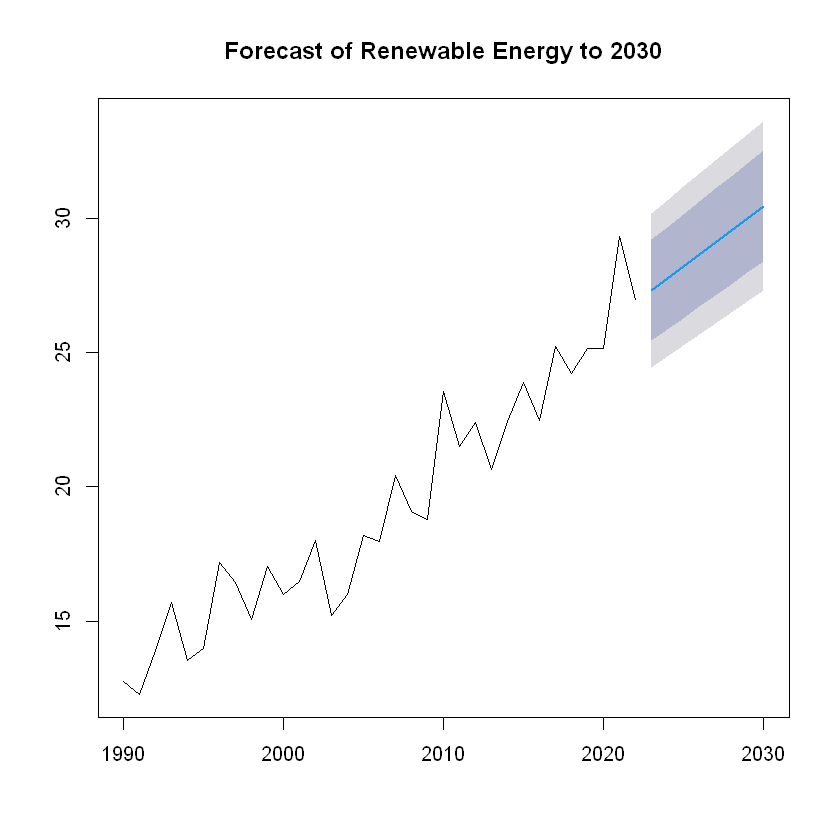

In [13]:
forecasted <- forecast(model, h = 8)  # 2023 to 2030
plot(forecasted, main = "Forecast of Renewable Energy to 2030")

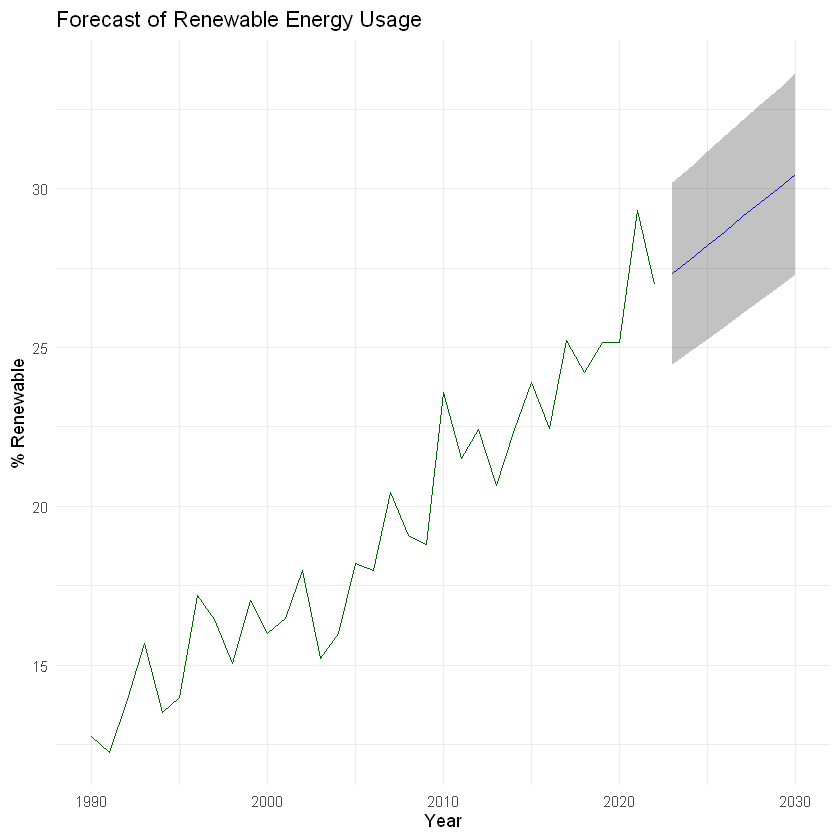

In [14]:
# Convert forecast to data frame for plotting
forecast_df <- data.frame(
  Year = 2023:2030,
  Forecast = forecasted$mean,
  Lower = forecasted$lower[,2],
  Upper = forecasted$upper[,2]
)

ggplot() +
  geom_line(data = data, aes(x = Year, y = Renewable_Energy_Percent), color = "darkgreen") +
  geom_line(data = forecast_df, aes(x = Year, y = Forecast), color = "blue") +
  geom_ribbon(data = forecast_df, aes(x = Year, ymin = Lower, ymax = Upper), alpha = 0.3) +
  labs(title = "Forecast of Renewable Energy Usage", y = "% Renewable", x = "Year") +
  theme_minimal()

2030 Normal: 30.5 %
2030 Policy: 42.5 %


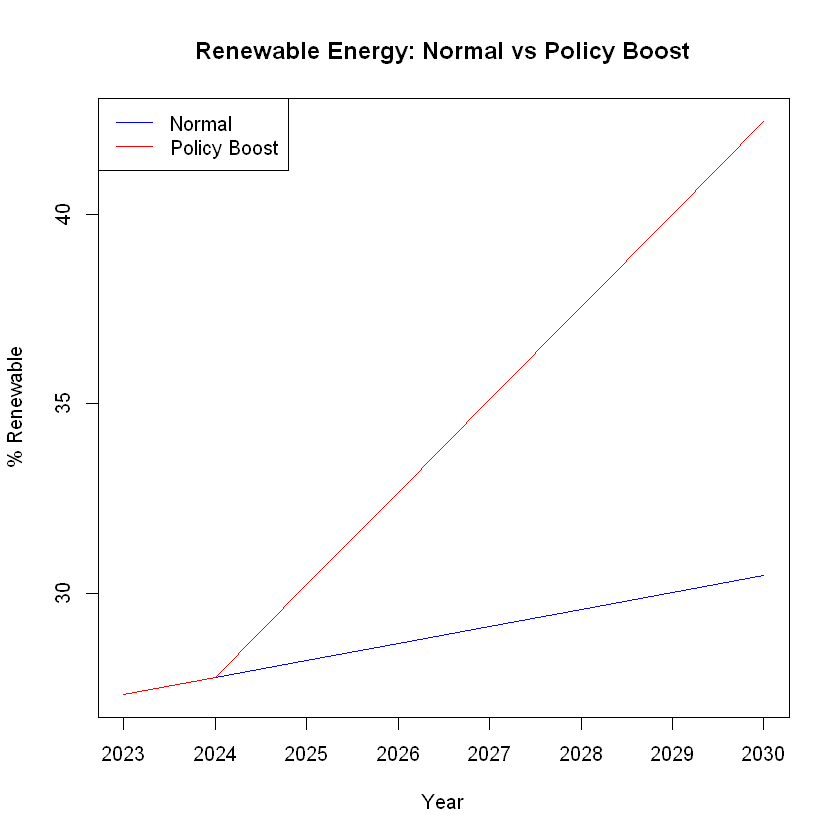

In [15]:
# Step 9 Scenario 1: Policy boost adds 2% per year from 2025
policy_boost <- forecasted$mean
for(i in 3:8) {  # 2025 onwards (3rd year = 2025)
  policy_boost[i] <- policy_boost[i] + 2 * (i - 2)
}

# Plot comparison
plot(2023:2030, forecasted$mean, type = "l", col = "blue", 
     ylim = c(min(forecasted$mean), max(policy_boost)), 
     main = "Renewable Energy: Normal vs Policy Boost",
     xlab = "Year", ylab = "% Renewable")
lines(2023:2030, policy_boost, col = "red")
legend("topleft", c("Normal", "Policy Boost"), col = c("blue", "red"), lty = 1)

cat("2030 Normal:", round(forecasted$mean[8], 1), "%\n")
cat("2030 Policy:", round(policy_boost[8], 1), "%\n")

2030 Range with high volatility: 24.2 to 36.8 %


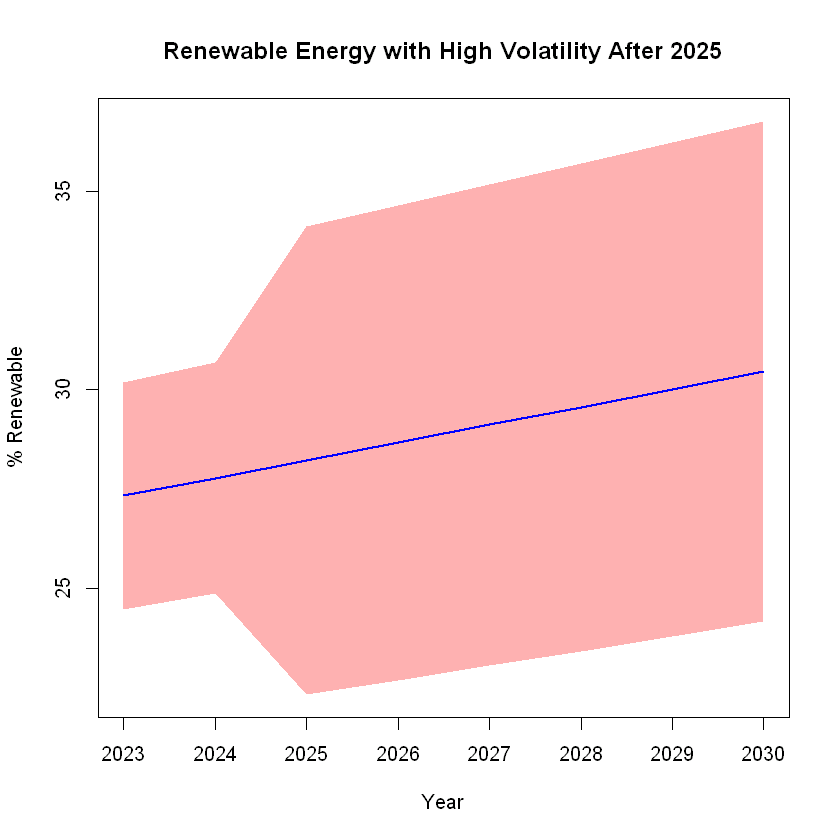

In [16]:
# Step 9 Scenario 2: Increased volatility after 2025
set.seed(123)

# Create wider confidence bands after 2025
normal_upper <- forecasted$upper[,2]
normal_lower <- forecasted$lower[,2]

# Double the uncertainty after 2025
high_vol_upper <- normal_upper
high_vol_lower <- normal_lower

for(i in 3:8) {  # 2025 onwards
  uncertainty <- (normal_upper[i] - normal_lower[i]) / 2
  high_vol_upper[i] <- forecasted$mean[i] + uncertainty * 2
  high_vol_lower[i] <- forecasted$mean[i] - uncertainty * 2
}

# Plot with high volatility
plot(2023:2030, forecasted$mean, type = "l", col = "blue",
     ylim = c(min(high_vol_lower), max(high_vol_upper)),
     main = "Renewable Energy with High Volatility After 2025",
     xlab = "Year", ylab = "% Renewable")
polygon(c(2023:2030, 2030:2023), c(high_vol_upper, rev(high_vol_lower)), 
         col = rgb(1,0,0,0.3), border = NA)
lines(2023:2030, forecasted$mean, col = "blue", lwd = 2)

cat("2030 Range with high volatility:", round(high_vol_lower[8], 1), "to", round(high_vol_upper[8], 1), "%\n")